In this notebook we start the modelling of the data with an XGBoost model and obtain the submission csv file.

# Modelling

In [1]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time
from xgboost import plot_importance
from xgboost import XGBRegressor

pd.options.display.max_rows = None

Read the data from 1_data_prep.

In [2]:
ts = time.time()
data = pd.read_pickle('data.pkl')
time.time() - ts

3.2769126892089844

Read the test file we need for submission

In [3]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

We use month 33 (October 2015) as validation for training. Month 34 (November 2015) is our test period.

Here we implicitly assume that the trends observed in October persist in November. An alternative would be to use November 2014 as our validation data, and only use previous data for training.

In [4]:
X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']
del data
del X
gc.collect();

We train the XGBRegressor() with optimized hyperparameters. **Note:** The model has been serialized and can be loaded below this cell. 

In [5]:
ts = time.time()

model = XGBRegressor(
    seed = 1,    
    n_estimators = 1000,
    max_depth = 10,    
    min_child_weight = 0.5, 
    colsample_bytree = 0.8, 
    subsample = 0.8, 
    eta = 0.1,
    )

model.fit(
    X_train, 
    y_train, 
    eval_metric = "rmse", 
    eval_set = [(X_train, y_train), (X_val, y_val)], 
    verbose = True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.17275	validation_1-rmse:1.11646
[1]	validation_0-rmse:1.11806	validation_1-rmse:1.07611
[2]	validation_0-rmse:1.07335	validation_1-rmse:1.04283
[3]	validation_0-rmse:1.04080	validation_1-rmse:1.02012
[4]	validation_0-rmse:1.00787	validation_1-rmse:0.99768
[5]	validation_0-rmse:0.97908	validation_1-rmse:0.97929
[6]	validation_0-rmse:0.95589	validation_1-rmse:0.96323
[7]	validation_0-rmse:0.93687	validation_1-rmse:0.95087
[8]	validation_0-rmse:0.92192	validation_1-rmse:0.94217
[9]	validation_0-rmse:0.90813	validation_1-rmse:0.93406
[10]	validation_0-rmse:0.89295	validation_1-rmse:0.92709
[11]	validation_0-rmse:0.88196	validation_1-rmse:0.92250
[12]	validation_0-rmse:0.87231	validation_1-rmse:0.91725
[13]	validation_0-rmse:0.86315	validation_1-rmse:0.91482
[14]	validation_0-rmse:0.85520	validation_1-rmse:0.91097
[15]	validation_0-rmse:0.84936	validation_1-rmse:0.90874
[16]	validation_0-rmse:0.84311	validation_1-rmse:0.90653
[17]	validation_0-rmse:0.83767	validation

2780.815128803253

In [6]:
filename = 'xgb_model_best.save'

In [7]:
#pickle.dump(model, open(filename, 'wb'))

In [8]:
model = pickle.load(open(filename, 'rb'))

In [9]:
print('Best validation score:', model.best_score)
print('Best iteration:', model.best_iteration)

Best validation score: 0.890877
Best iteration: 49


In [10]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('xgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.502589
1,1,0.111008
2,2,1.162530
3,3,0.600008
4,4,1.504177


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

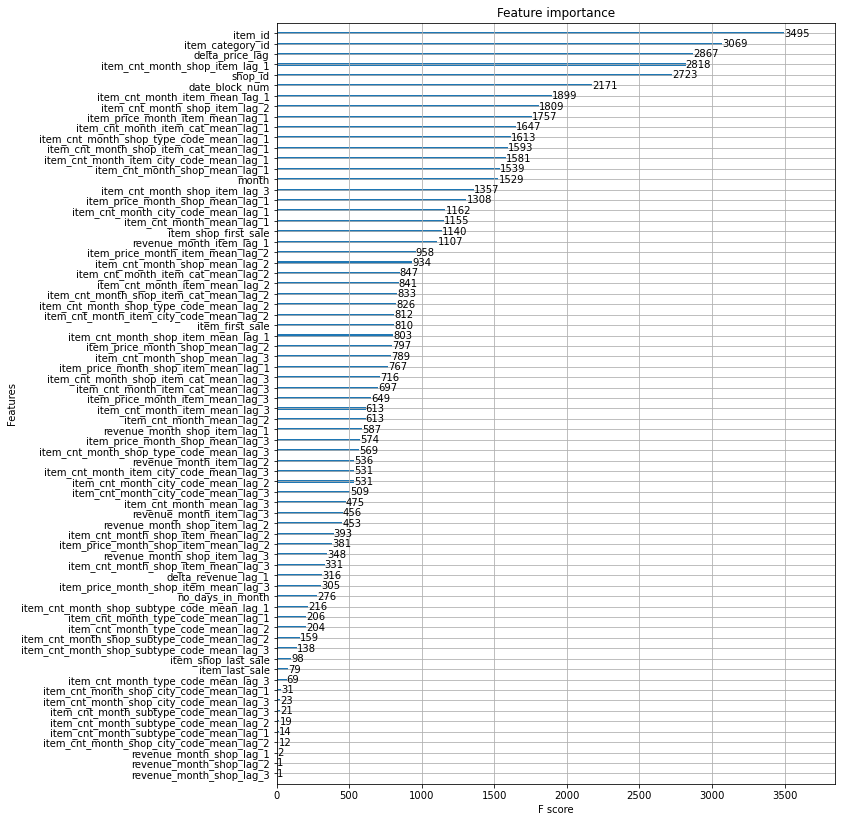

In [11]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    return plot_importance(booster = booster, ax = ax)

plot_features(model, (10, 14))

In [12]:
print('Number of total features:', len(model.feature_importances_))
features_to_keep = [feature for feature in list(X_train.columns) if feature in model.get_booster().get_score()]
print('Number of features with non-zero feature importance:', len(features_to_keep))
print('Features with zero feature importance:', set(list(X_train.columns)) - set(features_to_keep))

Number of total features: 78
Number of features with non-zero feature importance: 72
Features with zero feature importance: {'category_code', 'type_code', 'item_name3', 'subtype_code', 'city_code', 'item_name2'}


# Evaluation of model
Train score: 0.77318,
validation score: 0.890877,
public LB score: 0.955713,
private LB score: 0.956088